<a href="https://colab.research.google.com/github/daini10421/Model-Driven-Deep-Learning-For-MIMO-Detection/blob/main/Copy_of_network_ini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import tensorflow as tf
import numpy as np
import scipy.io as sc
import os
from scipy.linalg import toeplitz
import math
import matplotlib.pyplot as plt


tf.compat.v1.disable_eager_execution()

# Set environment variable
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Parameters
reuse = tf.compat.v1.AUTO_REUSE
N = 16
M = 16
snrdb_train = np.array([25.], dtype=np.float64)  # training SNR
snr_train = 10.0 ** (snrdb_train / 10.0)  # train_SNR_linear
batch_size = 100
epochs = 40
itermax = 10

train_size = 6400
valid_size = 1600
errsum = 1000  # Compute error total
rho = 0.50
snrdb_test = snrdb_train
snr_test = 10.0 ** (snrdb_test / 10.0)  # train_SNR_linear
# weight_mat = '/content/train.csv'

Rx = np.logspace(0, np.log10(rho**(M - 1)), M)
Tx = np.logspace(0, np.log10(rho**(N - 1)), N)
sigma2 = 1 / snr_test

# def Save(weight_file):
#     dict_name = {}
#     for varable in tf.compat.v1.trainable_variables():
#         dict_name[varable.name] = varable.eval()
#     sc.savemat(weight_file, dict_name)
with tf.Graph().as_default():


    A_ = tf.keras.Input(shape=[2 * M, 2 * N], dtype=tf.float64)
    H_ = tf.keras.Input(shape=[2 * N, 2 * M], dtype=tf.float64)
    X_ = tf.keras.Input(shape=[2 * N], dtype=tf.float64)
    Y_ = tf.keras.Input(shape=[2 * M], dtype=tf.float64)

    s = tf.zeros((batch_size, 2 * N, 1), dtype=tf.float64)
    tau2 = 1
    sigma2 = 10.0**(-snrdb_test / 10.0)
    eps = 1e-10
    v2 = tf.ones((batch_size,), dtype=tf.float64)
    beta = 5e-1
    IM = tf.eye(2 * M, batch_shape=[batch_size], dtype='float64')
    IN = tf.eye(2 * N, batch_shape=[batch_size], dtype='float64')
    with tf.compat.v1.variable_scope('gamma', reuse=reuse):
        gamma = tf.compat.v1.get_variable('gamma', shape=(itermax,), dtype=tf.float32, initializer=tf.zeros_initializer())
    with tf.compat.v1.variable_scope('gamma1', reuse=reuse):
        gamma1 = tf.compat.v1.get_variable('gamma1', shape=(itermax,), dtype=tf.float32, initializer=tf.zeros_initializer())
    with tf.compat.v1.variable_scope('corre'):
        corre = tf.compat.v1.get_variable('corre', shape=(itermax,), dtype=tf.float32, initializer=tf.zeros_initializer())
    with tf.compat.v1.variable_scope('expec'):
        expec = tf.compat.v1.get_variable('expec', shape=(itermax,), dtype=tf.float32, initializer=tf.zeros_initializer())

        for t in range(itermax):
         v2M = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(v2, axis=-1), axis=-1), [1, 2 * M, 2 * M])
         v2N = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(v2, axis=-1), axis=-1), [1, 2 * N, 2 * M])
         RR = tf.linalg.inv(tf.multiply(v2M, tf.matmul(A_, tf.linalg.matrix_transpose(A_))) + sigma2 * IM / 2)
         W = tf.multiply(v2N, tf.matmul(A_, RR, adjoint_a=True))
         tr = tf.linalg.trace(tf.matmul(W, A_))
         tr = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(tr, axis=-1), axis=-1), [1, 2 * N, 2 * M])
         W = 2 * N / tr * W
         z = tf.compat.v1.expand_dims(Y_, -1) - tf.matmul(A_, s)
         r = s + tf.cast(gamma[t], s.dtype) * tf.linalg.matmul(W, z)
         v2 = tf.maximum(
            tf.compat.v1.div(tf.norm(z, axis=[-2, -1])**2 - M * sigma2, tf.linalg.trace(tf.matmul(A_, A_, adjoint_a=True))),
            eps)
         B = IN - tf.cast(gamma1[t], s.dtype) * tf.matmul(W, A_)
         tau2 = v2 / 2 / N * tf.linalg.trace(tf.matmul(B, B, adjoint_b=True)) + tf.cast(gamma1[t], dtype=tf.float64) * tf.cast(gamma1[t], dtype=tf.float64) * sigma2 / 4 / N * tf.linalg.trace(
            tf.matmul(W, W, adjoint_b=True))

        #  s = shrink_bg_QPSK(r, tau2)
         s = tf.cast(corre[t], dtype=tf.float64) * (s - tf.cast(expec[t], dtype=tf.float64) * r)

    s = s[:, :, 0]
    cost = tf.nn.l2_loss(s - X_)  # l2 loss function
    err_temp = tf.compat.v1.to_float(tf.compat.v1.not_equal(tf.compat.v1.sign(s), tf.compat.v1.sign(X_)))
    err = tf.reduce_sum(err_temp)
    ser = tf.reduce_mean(err_temp)

    with tf.compat.v1.variable_scope('opt', reuse=reuse):
        optimizer = tf.compat.v1.train.AdamOptimizer(0.001).minimize(cost)

    #Train()
    #update = Network_ini(sc.loadmat(weight_mat + 'oamp.mat'))
    #loss_test, ser_test, s_, gamma_, gamma1_, corre_, expec_ = Test(snrdb_test)

In [ ]:
# def Network_ini(theta):
#     update = []
#     for var in tf.compat.v1.trainable_variables():
#       var_name = var.name.split(':')[0]  # Remove the ':0' suffix from variable name
#       if var_name in theta:
#         update.append(tf.compat.v1.assign(tf.compat.v1.get_default_graph().get_tensor_by_name(var_name),
#                                           tf.constant(np.reshape(theta[var_name], var.shape))))
#     return update


def Network_ini():
    update = []
    with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
        for var in tf.compat.v1.trainable_variables():
            init_value = tf.random.normal(var.shape, dtype=var.dtype)
            update.append(tf.compat.v1.assign(var, init_value))
    return update


In [ ]:
def Variable(shape, name):
    return tf.compat.v1.get_variable(name, shape=shape, initializer=tf.ones_initializer, dtype='float64')

In [ ]:
def generate_data_iid_test(B, M, N, SNR_dB):
    y_real = np.zeros([2 * M, B])
    x_real = np.zeros([2 * N, B])
    H_real = np.zeros([B, 2 * M, 2 * N])
    snr = 10.0 ** (SNR_dB / 10.0)
    sigma2 = 1 / snr
    H_ = (np.random.randn(B, M, N) + 1j * np.random.randn(B, M, N)) / np.sqrt(2 * M)
    x_ = Modulation((np.random.uniform(0, 1, (N, B)) < 0.5)) + 1j * Modulation((np.random.uniform(0, 1, (N, B)) < 0.5))
    y_ = np.zeros([M, B], dtype=complex)
    w = np.sqrt(1 / 2) * (np.random.randn(M, B) + 1j * np.random.randn(M, B)) * np.sqrt(sigma2)
    for i in range(B):
        H = H_[i, :, :]
        y_[:, i] = np.matmul(H, x_[:, i]) + w[:, i]
        y_real[:, i] = np.hstack((np.real(y_[:, i]), np.imag(y_[:, i]))).T
        H_real[i, :, :] = np.vstack((np.hstack((np.real(H), -np.imag(H))), np.hstack((np.imag(H), np.real(H)))))
        x_real[:, i] = np.hstack((np.real(x_[:, i]), np.imag(x_[:, i]))).T
    # print(H_)
    return y_real, H_real, x_real

In [ ]:
def Modulation(bits):
    x_re = (2 * bits - 1) / np.sqrt(2)
    return x_re


In [ ]:
def shrink_bg_QPSK(r, rvar):
    b = 2 * phi(-1 / np.sqrt(2), r, rvar)
    tp = phi(-1 / np.sqrt(2), r, rvar) + phi(1 / np.sqrt(2), r, rvar)
    a = 1 - tf.compat.v1.div(b, tp)
    xhat_ = a / np.sqrt(2)
    return xhat_

In [ ]:
def phi(x, r, rvar):
    rvar = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(rvar, axis=-1), axis=-1), [1, 2 * N, 1])
    y = tf.compat.v1.maximum(tf.compat.v1.exp(-tf.compat.v1.square(x - r) / (2 * rvar)), eps)
    return y

In [ ]:
def Train_batch(sess):
    _loss = list()
    _ser = list()
    packet = valid_size // batch_size
    for offset in range(packet):
        batch_Y, batch_H, batch_X = generate_data_iid_test(batch_size, M, N, snrdb_train)
        _, b_loss, b_ser = sess.run([optimizer, cost, ser], {Y_: batch_Y.T, A_: batch_H, X_: batch_X.T})
        _loss.append(b_loss)
        _ser.append(b_ser)
    return np.mean(_loss), np.mean(_ser)

In [ ]:
def Valid_batch(sess):
    _loss = []
    _ser = []
    packet = valid_size // batch_size
    for offset in range(packet):
        batch_Y, batch_H, batch_X = generate_data_iid_test(batch_size, M, N, snrdb_test)
        b_loss, b_ser = sess.run([cost, ser], {Y_: batch_Y.T, A_: batch_H, X_: batch_X.T})
        _loss.append(b_loss)
        _ser.append(b_ser)
    return np.mean(_loss), np.mean(_ser)

In [ ]:
def plot_performance(train_loss_list, valid_loss_list, train_ser_list, valid_ser_list):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(valid_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(len(train_loss_list)), np.arange(1, len(train_loss_list) + 1))
    plt.xticks(np.arange(len(valid_loss_list)), np.arange(1, len(valid_loss_list) + 1))

    plt.subplot(2, 1, 2)
    plt.plot(train_ser_list, label='Training SER')
    plt.plot(valid_ser_list, label='Validation SER')
    plt.title('Training and Validation SER')
    plt.xlabel('Epoch')
    plt.ylabel('SER')
    plt.legend()
    plt.xticks(np.arange(len(train_ser_list)), np.arange(1, len(train_ser_list) + 1))
    plt.xticks(np.arange(len(valid_ser_list)), np.arange(1, len(valid_ser_list) + 1))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
def plot_performance1(test_loss_list,test_ser_list):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(test_loss_list, label='Testing Loss')
    plt.title('Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.grid(True)
    plt.xticks(np.arange(len(test_loss_list)), np.arange(1, len(test_loss_list) + 1))

    plt.subplot(2, 1, 2)
    plt.plot(np.divide(test_ser_list,10) , label='Testing SER')
    plt.title('Testing SER')
    plt.xlabel('Epoch')
    plt.ylabel('SER')
    plt.legend()
    # plt.grid(True)
    plt.xticks(np.arange(len(test_ser_list)), np.arange(1, len(test_ser_list) + 1))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
def Train():
    print("\nTraining ...")
    with tf.compat.v1.Session() as sess:
        tf.compat.v1.global_variables_initializer().run()
        # weight_file = weight_mat
        best_valid_loss = float('inf')

        train_loss_list = []
        valid_loss_list = []
        train_ser_list = []
        valid_ser_list = []

        for i in range(epochs):
            start_time = time.time()
            train_loss, ser_train = Train_batch(sess)
            valid_loss, ser_valid = Valid_batch(sess)
            time_taken = time.time() - start_time
            print("Epoch %d Valid Loss: %.8f, Valid SER: %.8f, Time Cost: %.2f s"
                  % (i + 1, valid_loss, ser_valid, time_taken))

            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            train_ser_list.append(ser_train)
            valid_ser_list.append(ser_valid)

            corre_val = sess.run(corre)
            print("Corre values:", corre_val)

            gamma_val = sess.run(gamma)
            print("Gamma values:", gamma_val)

            gamma1_val = sess.run(gamma1)
            print("Gamma1 values:", gamma1_val)

            expec_val = sess.run(expec)
            print("Expec values:", expec_val)


            if i == 0 or (i > 0 and valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                Save()

        plot_performance(train_loss_list, valid_loss_list, train_ser_list, valid_ser_list)

        print("\nTraining is finished.")

In [ ]:
def Test(snr_test):
    with tf.compat.v1.Session() as sess:
        tf.compat.v1.global_variables_initializer().run()
        sess.run(update)
        test_loss_list = []
        test_ser_list = []

        for i in range(epochs):
            start_time = time.time()
            test_loss, ser_test = Test_batch(sess)
            time_taken = time.time() - start_time
            print("Epoch %d Test Loss: %.8f, Test SER: %.8f, Time Cost: %.2f s"
                  % (i + 1, test_loss, ser_test, time_taken))

            test_loss_list.append(test_loss)
            test_ser_list.append(ser_test)


        plot_performance1(test_loss_list, test_ser_list)

        # loss_test, ser_test, s_, gamma_, gamma1_, corre_, expec_ = Test_batch(sess)
        loss_test, ser_test = Test_batch(sess)
        print("Eb/N: %.0f, Testing Loss: %.8f, Testing SER: %.8f" % (snr_test, loss_test, ser_test))
    # return loss_test, ser_test, s_, gamma_, gamma1_, corre_, expec_

In [ ]:
def Test_batch(sess):
    _loss = []
    _ser = []
    sernum = 0
    while sernum < errsum:
        batch_Y, batch_H, batch_X = generate_data_iid_test(batch_size, M, N, snrdb_test)
        _,b_loss, b_ser, errnum, s_, gamma_, gamma1_, corre_, expec_ = sess.run(
            [optimizer,cost, ser, err, s, gamma, gamma1, corre, expec], {Y_: batch_Y.T, A_: batch_H, X_: batch_X.T})
        _loss.append(b_loss)
        _ser.append(b_ser)
        sernum = sernum + errnum
    # return np.mean(_loss), np.mean(_ser), s_, gamma_, gamma1_, corre_, expec_
    return np.mean(_loss), np.mean(_ser)

In [ ]:
# def Save(weight_file):
def Save():
    dict_name = {}
    for varable in tf.compat.v1.trainable_variables():
        dict_name[varable.name] = varable.eval()
    # sc.savemat(weight_file, dict_name)


Training ...
Epoch 1 Valid Loss: 846.00713991, Valid SER: 0.53947270, Time Cost: 5.61 s
Corre values: [0.99847305 1.00146218 0.99846102 1.00151434 0.99845229 1.00153928
 0.99845627 1.00157125 0.99843146 0.99840986]
Gamma values: [1.00141977 0.9986167  1.00145416 0.99852292 1.00150061 0.99845883
 1.00156286 0.99880497 0.99841077 0.99840104]
Gamma1 values: [1.00125616 0.99914342 1.00139998 0.99908082 1.00138696 0.99894941
 1.00138734 0.99889583 1.00136458 0.99885346]
Expec values: [1.00142808 0.99848784 1.00150123 0.99847067 1.00152383 0.99844611
 1.00156589 0.99857602 0.99841025 0.99840077]
Epoch 2 Valid Loss: 838.76448664, Valid SER: 0.52960938, Time Cost: 4.48 s
Corre values: [0.99704465 1.00296907 0.99702542 1.00306457 0.99699286 1.00312126
 0.99700018 1.00317015 0.99688414 0.99685239]
Gamma values: [1.00289433 0.99725772 1.0029517  0.99704144 1.0030048  0.99692952
 1.00310488 0.99783764 0.99684049 0.99680569]
Gamma1 values: [1.00223669 0.99882104 1.00258406 0.99844822 1.00259689 0.

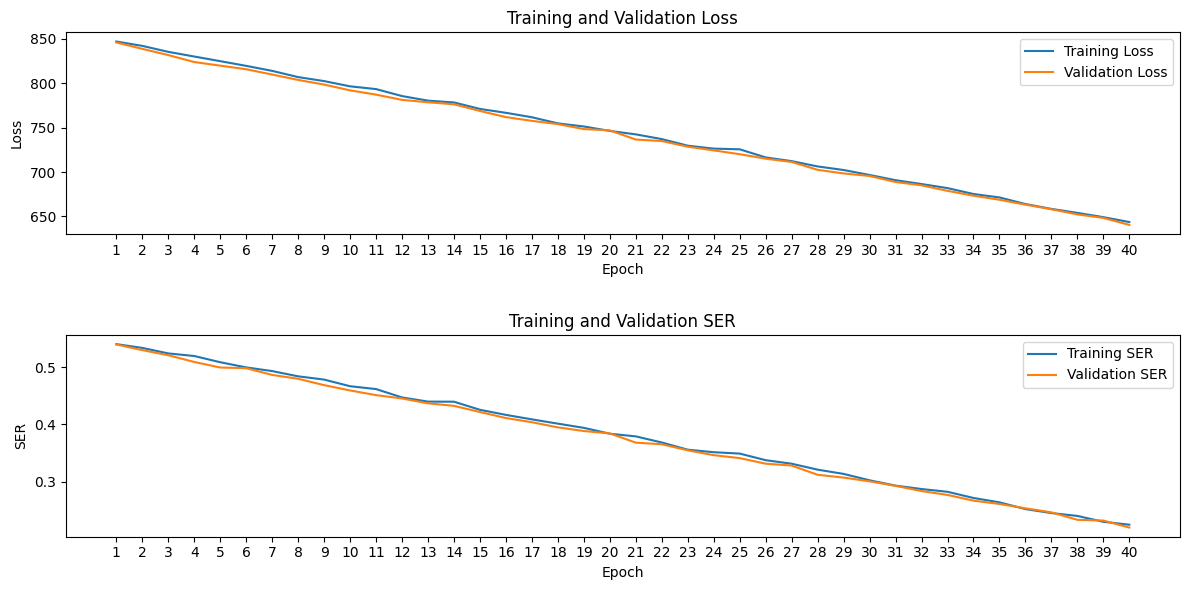


Training is finished.
Epoch 1 Test Loss: 326.93486875, Test SER: 0.00228714, Time Cost: 24.01 s
Epoch 2 Test Loss: 115.48021994, Test SER: 0.00227582, Time Cost: 21.84 s
Epoch 3 Test Loss: 63.10728022, Test SER: 0.00217014, Time Cost: 22.05 s
Epoch 4 Test Loss: 52.09099427, Test SER: 0.00219401, Time Cost: 23.12 s
Epoch 5 Test Loss: 50.58137138, Test SER: 0.00221853, Time Cost: 22.58 s
Epoch 6 Test Loss: 49.03193581, Test SER: 0.00204453, Time Cost: 24.38 s
Epoch 7 Test Loss: 48.81675998, Test SER: 0.00199841, Time Cost: 24.97 s
Epoch 8 Test Loss: 47.94258191, Test SER: 0.00199096, Time Cost: 25.08 s
Epoch 9 Test Loss: 46.98073710, Test SER: 0.00201613, Time Cost: 24.55 s
Epoch 10 Test Loss: 46.15504531, Test SER: 0.00186570, Time Cost: 26.32 s
Epoch 11 Test Loss: 44.84277898, Test SER: 0.00174930, Time Cost: 28.06 s
Epoch 12 Test Loss: 43.65734252, Test SER: 0.00178090, Time Cost: 27.63 s
Epoch 13 Test Loss: 41.47835937, Test SER: 0.00160555, Time Cost: 31.56 s
Epoch 14 Test Loss: 38

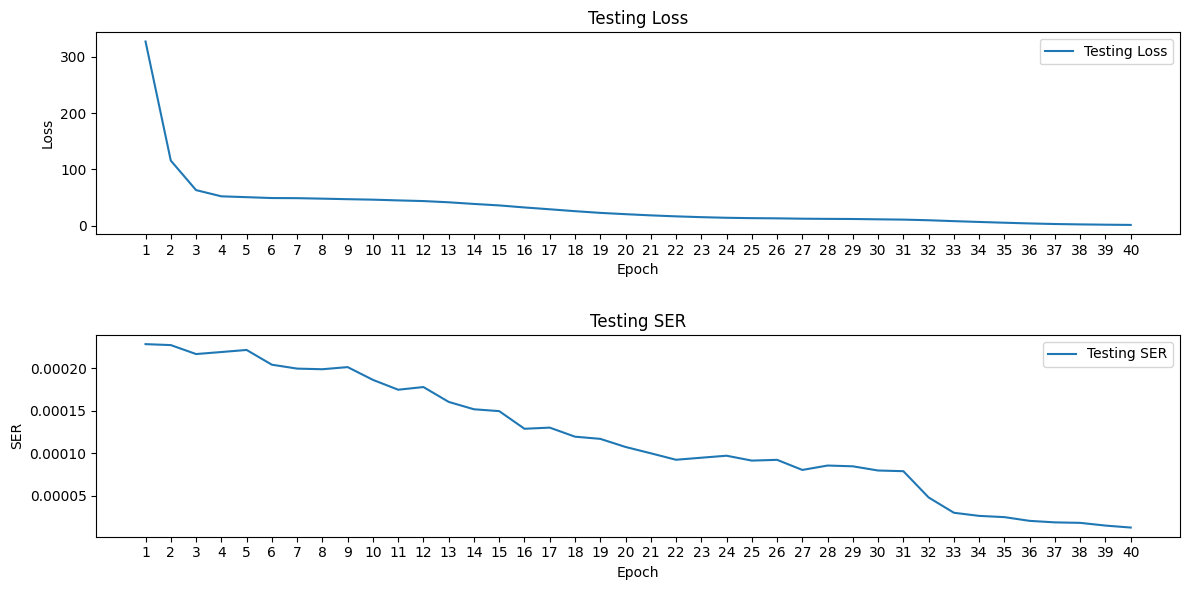

Eb/N: 25, Testing Loss: 1.00479820, Testing SER: 0.00010026


<ipython-input-215-d3ebcf300bfe>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Eb/N: %.0f, Testing Loss: %.8f, Testing SER: %.8f" % (snr_test, loss_test, ser_test))


In [ ]:
with tf.compat.v1.Graph().as_default():
    A_ = tf.compat.v1.placeholder(tf.float64, shape=[None, 2 * M, 2 * N])
    X_ = tf.compat.v1.placeholder(tf.float64, shape=[None, 2 * N])
    Y_ = tf.compat.v1.placeholder(tf.float64, shape=[None, 2 * M])
    s = tf.zeros((batch_size, 2 * N, 1), dtype=tf.float64)
    tau2 = 1
    sigma2 = 10.0**(-snrdb_test / 10.0)
    eps = 1e-10
    v2 = tf.ones((batch_size,), dtype=tf.float64)
    beta = 5e-1
    IM = tf.eye(2 * M, batch_shape=[batch_size], dtype='float64')
    IN = tf.eye(2 * N, batch_shape=[batch_size], dtype='float64')

    with tf.compat.v1.variable_scope('gamma', reuse=reuse):
        gamma = Variable((itermax,), 'gamma')
    with tf.compat.v1.variable_scope('gamma1', reuse=reuse):
        gamma1 = Variable((itermax,), 'gamma1')
    with tf.compat.v1.variable_scope('corre'):
        corre = Variable((itermax,), 'corre')
    with tf.compat.v1.variable_scope('expec'):
        expec = Variable((itermax,), 'expec')

    for t in range(itermax):
        v2M = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(v2, axis=-1), axis=-1), [1, 2 * M, 2 * M])
        v2N = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(v2, axis=-1), axis=-1), [1, 2 * N, 2 * M])
        RR = tf.linalg.inv(tf.multiply(v2M, tf.matmul(A_, tf.linalg.matrix_transpose(A_))) + sigma2 * IM / 2)
        W = tf.multiply(v2N, tf.matmul(A_, RR, adjoint_a=True))
        tr = tf.linalg.trace(tf.matmul(W, A_))
        tr = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(tr, axis=-1), axis=-1), [1, 2 * N, 2 * M])
        W = 2 * N / tr * W
        z = tf.compat.v1.expand_dims(Y_, -1) - tf.matmul(A_, s)
        r = s + gamma[t] * tf.matmul(W, z)
        v2 = tf.maximum(
            tf.compat.v1.div(tf.norm(z, axis=[-2, -1])**2 - M * sigma2, tf.linalg.trace(tf.matmul(A_, A_, adjoint_a=True))),
            eps)
        B = IN - gamma1[t] * tf.matmul(W, A_)
        tau2 = v2 / 2 / N * tf.linalg.trace(tf.matmul(B, B, adjoint_b=True)) + gamma1[t] * gamma1[t] * sigma2 / 4 / N * tf.linalg.trace(
            tf.matmul(W, W, adjoint_b=True))
        s = shrink_bg_QPSK(r, tau2)
        s = corre[t] * (s - expec[t] * r)

    s = s[:, :, 0]
    cost = tf.nn.l2_loss(s - X_)  # l2 loss function
    err_temp = tf.compat.v1.to_float(tf.compat.v1.not_equal(tf.compat.v1.sign(s), tf.compat.v1.sign(X_)))
    err = tf.reduce_sum(err_temp)
    ser = tf.reduce_mean(err_temp)

    with tf.compat.v1.variable_scope('opt', reuse=reuse):
        optimizer = tf.compat.v1.train.AdamOptimizer(0.0001).minimize(cost)

    Train()
    update = Network_ini()
    # loss_test, ser_test, s_, gamma_, gamma1_, corre_, expec_ = Test(snrdb_test)
    Test(snrdb_test)